# ResNet20

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Check if CUDA is available and set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Transform for the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261))
])

# Load CIFAR-10 training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

# Load model and move to device
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
model.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Function to calculate accuracy
def calculate_accuracy(net, dataloader, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# # Evaluate on the training data
# train_accuracy = calculate_accuracy(model, trainloader, device)
# print('Accuracy of the network on the training images: %d %%' % train_accuracy)

# Evaluate on the test data
test_accuracy = calculate_accuracy(model, testloader, device)
print('Accuracy of the network on the test images: %d %%' % test_accuracy)


Using device: cuda:0
Files already downloaded and verified
Files already downloaded and verified


/home/yo46/anaconda3/envs/llmattack/lib/python3.8/site-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /home/yo46/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet20-4118986f.pt" to /home/yo46/.cache/torch/hub/checkpoints/cifar10_resnet20-4118986f.pt
100%|██████████| 

Accuracy of the network on the test images: 92 %


In [2]:
def create_initial_patch(size=(10, 10), device='cpu'):
    """Create an initial random patch."""
    patch = torch.rand((3,) + size, requires_grad=True, device=device)  # Add channel dimension
    return patch

def apply_patch(original_images, patch):
    """Apply the patch to the top-left corner of each image in a batch."""
    patched_images = original_images.clone()
    c, h, w = patch.shape  # Get the shape of the patch
    patched_images[:, :, :h, :w] = patch  # Apply the patch
    return patched_images

def train_patch(model, patch, train_loader, device='cpu', epochs=5):
    """Train the patch to perform an untargeted attack."""
    optimizer = torch.optim.Adam([patch], lr=0.01)

    for epoch in range(epochs):
        total_loss = 0.0
        num_batches = 0

        for images, _ in train_loader:
            images = images.to(device)
            patched_images = apply_patch(images, patch)

            outputs = model(patched_images)
            loss = -torch.nn.functional.nll_loss(outputs, outputs.max(1)[1])
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

        average_loss = total_loss / num_batches
        print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {average_loss:.4f}")

    return patch


# Load your datasets and model here
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Create the initial patch
patch_size = (10, 10)  # Define the size of the patch
initial_patch = create_initial_patch(size=patch_size, device=device)

# Train the patch
trained_patch = train_patch(model, initial_patch, trainloader, device=device, epochs=20)



Epoch [1/20], Average Loss: 7.7600


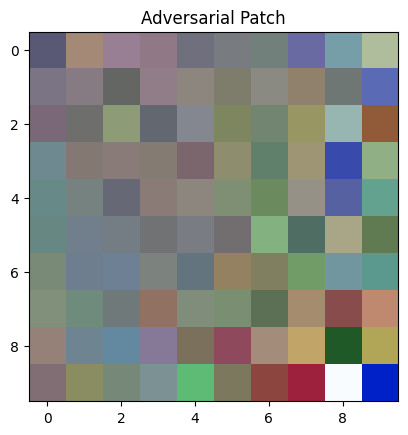

In [21]:
# Save or visualize the trained patch here 
def visualize_patch(patch):
    """Visualize the adversarial patch."""
    # Move patch to CPU and convert to numpy
    patch_np = patch.detach().cpu().numpy()
    
    # Reshape and normalize the patch for visualization
    patch_np = np.transpose(patch_np, (1, 2, 0))  # Change from (C, H, W) to (H, W, C)
    patch_np = (patch_np - patch_np.min()) / (patch_np.max() - patch_np.min())  # Normalize to [0, 1]

    plt.imshow(patch_np)
    plt.title("Adversarial Patch")
    plt.show()

# Visualize the trained patch
visualize_patch(trained_patch)

In [23]:
def test_model_with_patch(model, patch, test_loader, device):
    """Evaluate the model on the test set with the adversarial patch applied."""
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    predicted_distribution = torch.zeros(len(test_loader.dataset.classes), dtype=torch.int64)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            patched_images = apply_patch(images, patch)  # Apply the patch

            outputs = model(patched_images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)

            correct += (predicted == labels).sum().item()

            for label in predicted:
                predicted_distribution[label] += 1

    accuracy = 100 * correct / total
    return accuracy, predicted_distribution

accuracy_after_attack, label_distribution = test_model_with_patch(model, trained_patch, testloader, device)

print('Accuracy of the model after the attack: {:.2f} %'.format(accuracy_after_attack))
print('Predicted label distribution:', label_distribution.numpy())

Accuracy of the model after the attack: 47.41 %
Predicted label distribution: [ 351 1343  905 2179  167 2507  255 1335   30  928]


In [24]:
def train_patch_targeted(model, patch, train_loader, target_class, device='cpu', epochs=5):
    """Train the patch to perform a targeted attack."""
    optimizer = torch.optim.Adam([patch], lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        for images, _ in train_loader:
            target_labels = torch.full((len(images),), target_class, device=device)
            images = images.to(device)
            patched_images = apply_patch(images, patch)

            optimizer.zero_grad()
            outputs = model(patched_images)
            loss = criterion(outputs, target_labels)
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    return patch

patch_size = (10, 10)  # Define the size of the patch
initial_patch = create_initial_patch(size=patch_size, device=device)
target_class = 5  # Example: 0 for the first class in CIFAR-10
trained_patch_targeted = train_patch_targeted(model, initial_patch, trainloader, target_class, device=device, epochs=20)


Epoch [1/20], Loss: 0.7360
Epoch [2/20], Loss: 0.3309
Epoch [3/20], Loss: 0.2583
Epoch [4/20], Loss: 0.2141
Epoch [5/20], Loss: 0.1872
Epoch [6/20], Loss: 0.1659
Epoch [7/20], Loss: 0.1503
Epoch [8/20], Loss: 0.1313
Epoch [9/20], Loss: 0.1162
Epoch [10/20], Loss: 0.1035
Epoch [11/20], Loss: 0.0946
Epoch [12/20], Loss: 0.0876
Epoch [13/20], Loss: 0.0787
Epoch [14/20], Loss: 0.0682
Epoch [15/20], Loss: 0.0602
Epoch [16/20], Loss: 0.0543
Epoch [17/20], Loss: 0.0499
Epoch [18/20], Loss: 0.0460
Epoch [19/20], Loss: 0.0430
Epoch [20/20], Loss: 0.0410


In [26]:
accuracy_after_attack, label_distribution = test_model_with_patch(model, trained_patch_targeted, testloader, device)

print('Accuracy of the model after the attack: {:.2f} %'.format(accuracy_after_attack))
print('Predicted label distribution:', label_distribution.numpy())

Accuracy of the model after the attack: 10.69 %
Predicted label distribution: [   3   10    1    3   11 9931    1    7    4   29]
